Assumptions: 
* Can represent $m_i$ as a linear combination of (potentially shifted) $m_p, \cdots, m_q \in \mathcal{N}^*(i)$. 
* Need to have reconstructed data over all time points where we are going to predict.
* $\exists \tau \geq 0: x_i(t) \approx x_j(t - \tau)$
* $\mathcal{A} = \left \{ A \in \mathbb{R}^{N \times N} \mid A^\top = A, A_{i, j} \geq 0 \forall i,j,   \right \}$ 

**Hypothesis**:
* The interpolated regions in our reconstructed screening histories exhibit patterns that can be organized into distinct sub-networks and our algorihtm is capable of indicating these networks.

**Approach**: 
* What kind of network do we seek?
    - A trade-off between global and local smoothness over graph signals.

In [1]:
from scipy import signal
from scipy.sparse import csgraph
from sklearn.linear_model import Ridge

from sklearn.metrics import pairwise_distances, jaccard_score

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O

# The Algorithm

Our goal is to derive an adjacency matrix $\left \{ A \in \mathcal{A} \mid A = A^\top, A_{i,j} \geq 0 \right \}$ connecting together signal vectors $m \in M$ by trading off local for global smoothness. We measure local smoothness over the neighbourhood $\mathcal{N}(i)$ of node $i$ as $m_i - \hat{m_i}$ where 

$$
    \hat{m}_i = \sum_{j \in \mathcal{N}^*(i)} S^{\tau^*_j}m_j \beta^*_j, \quad \tau^*_j = \arg \max_t (m_i \star m_j)(t)
$$    
$$
    \beta^*  = \min_{\beta, \sum_j \beta_j = 1} \left \| m_i - \sum_{j \in \mathcal{N}^*(i)} S^{\tau^*_j} m_j \beta_j \right  \|_2^2.
$$

Here, $j \in \mathcal{N}^*(i)$ is the refined neighbour of node $i$. Each $j$ associate a signal vector $m_j$, which we aligned to $m_i$ by means of cross-correlation and the shift operator $S^{\tau^*} m_j = m_j(t - \tau^*)$. Node $j$ is only included in $\mathcal{N}^*(i)$ if $\max_t (m_i \star m_j)(t) > \epsilon$. This can potentially reduce density of $A$ for larger $\epsilon$ by removing edges originally in $A$, making $A$ more sparse. The global smoothness we measure using $tr (\hat{M}^\top L \hat{M} )$.

We define the energy over the graph as

$$
    E(A) = \beta \left \| M - \hat{M} \right \|_F^2 + (1 - \beta) tr (\hat{M}^\top L \hat{M} ).
$$

By adapting the simulated annealing (SA) algorithm to our purpose, we seek the $A$ that minimizes $E$. The SA algorithm minimizes a function over a budget of $N$ iterations. For each iteration $n + 1 \leq N$, a candidate adjacency matrix $A_{n+1}$ is selected at random. With $A_{n+1}$, we compute $E(A_{n + 1})$ and evaluate 
$$
    P(E(A_n), E(A_{n + 1}), T(n)) \geq u
$$
for $u \sim U(0, 1)$. Here $P(\cdot)$ gives the probability of accepting $A_{n+1}$ as the current adjacency matrix (i.e. transition probailities) and $T(n)$ is the *annealing function* evalauted at step $n$. We currently define $P$ as 

$$
P(E(A_n), E(A_{n + 1}), T(n)) = \begin{cases}
1 & \text{ if } E(A_{n+1}) < E(A_n) \\ 
\exp\left ( - \left ( \frac{E(A_{n+1}) - E(A_n)}{T} \right ) \right ) & \text{ otherwise }
\end{cases}
$$

and use an annealing schedule

$$
    T(n) =  \frac{T_0}{2} \left ( 1 - \tanh\left ( 10 \frac{n}{N} - 5 \right ) \right )
$$

with $T_0 = E(A_0)$ since is seems like a good idea to have $T_0 \propto E$. Some alternative annealing schedules are
$$
T(n) = \frac{T_0}{2} \left ( 1 + \cos\left ( \frac{n \pi}{N} \right ) \right ), \quad 
T(n) =  \frac{T_0}{\cosh(10 n / N)}
$$

Our first priority when generating a new candidate $A_{n+1}$ is to ensure that each node is connected to at least one neighbour. Suppose for node $i$ that $\mathcal{N}_n(i) = \emptyset$, then we randomly sample some node $j$ and connect $i$ to all neighbours of $j$. If, however, $\mathcal{N}_n(i) \neq \emptyset$ as well as $\mathcal{N}_n(j) \neq \emptyset$, we can rely on a mechanism for selecting a new candidate $A_{n+1}$ inspired by collaboratie filtering. For some node $i$, we compare $\mathcal{N}_n(i)$ to the neighbourhood $\mathcal{N}_n(j)$ of node $j$, after ensuring $i \notin \mathcal{N}_j$, by measuring the similarity between $\mathcal{N}_i$ and $\mathcal{N}_j$ using the Jaccard similarty 

$$
    J = \frac{\mathcal{N}_i \cap  \mathcal{N}_j}{\mathcal{N}_i \cup \mathcal{N}_j}.
$$

Here, $0 \leq J \leq 1$. If $J = 1$ we connect $i$ to $j$. However, if $J < 1 \Rightarrow \mathcal{N}_n(i) \cap  \mathcal{N}_n(j) < \max \left \{ \left | \mathcal{N}_n(i) \right |, \left | \mathcal{N}_n(j) \right | \right \}$ so assign $k \in \mathcal{N}_n(j) \setminus \mathcal{N}_n(i) \rightarrow \mathcal{N}_n(i)$. Here we can potentially update $\mathcal{N}_n(j)$ simultanously with $\mathcal{N}_n(j)$ but this approach will break if $\mathcal{N}_n(i) = \emptyset$ in the first place. Find k-NN using $J$ as similarity metric. This procedure will increase the density of $A$ and complements - to some degree - the neighbourhood refinement step.

**NOTE**
* Can relate $\epsilon$ to number of candidates and size of active set through some desired graph sparsity? Reduce number of parameters!

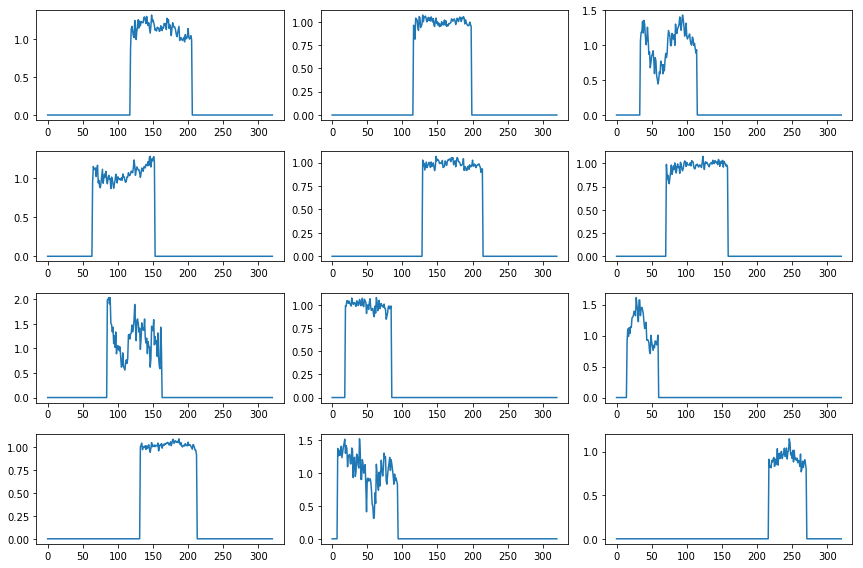

In [11]:
def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O


# Choose between synthetic and screening data for demonstration run.
#M = synthetic_data_gen()
M = screening_data_gen()

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

In [23]:
def intial_adjacency(n, p, seed):
    
    # Initialize with random adjancey.
    G = nx.erdos_renyi_graph(n=n, p=p, seed=seed, directed=False)
    return nx.to_numpy_array(G)


def check_iterable(N_i):
    """Check the data structure of a neighbourhood."""
    
    if isinstance(N_i, (int, float)):
        N_i = np.array([int(N_i)])
        
    if not isinstance(N_i, np.ndarray):
        N_i = np.array(N_i)
        
    if np.ndim(N_i) < 1:
        N_i = np.expand_dims(N_i, axis=0)
        
    return N_i


def energy(M, M_hat, A, beta):
    """Evaluate \min_{A} | M - M^* |_F^2 + \gamma tr((M^*)^\top L M^*)."""
    
    L = csgraph.laplacian(A, normed=True)
    
    loss_local = np.linalg.norm(M - M_hat) ** 2
    loss_global = np.trace(M_hat.T @ L @ M_hat)
    
    return beta * loss_local + (1 - beta) * loss_global


# See also: https://stackoverflow.com/questions/49733244/how-can-i-calculate-neighborhood-overlap-in-weighted-network
def neighbourhood_similarity(N_i, N_j):
    
    return jaccard_score(N_i != 0, N_j != 0)

# Annealing schedule

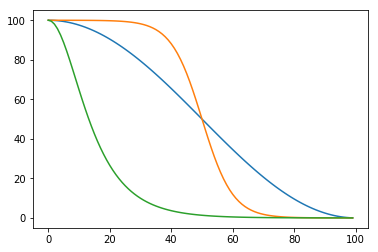

In [14]:
def annealing_schedule(T0, x):
    
    return 0.5 * T0 * (1 - np.tanh(10 * x / len(x) - 5))


# https://www.chegg.com/homework-help/questions-and-answers/hello-help-please-simulated-annealing-cooling-schedules-figure-1-various-cooling-schedules-q33202578

f1 = lambda T0, x: 0.5 * T0 * (1 + np.cos(x * np.pi / len(x)))
f2 = lambda T0, x: 0.5 * T0 * (1 - np.tanh(10 * x / len(x) - 5))
f3 = lambda T0, x: T0 / np.cosh(10 * x / len(x))
    
x = np.arange(100)
        
plt.figure()
plt.plot(f1(100, x))
plt.plot(f2(100, x))
plt.plot(f3(100, x))

# Acceptance probability

In [20]:
def p_accept(E, E_new, T):
    
    if E_new < E:
        return 1.0
    
    return np.exp(-1.0 * (E_new - E) / T)


# Magnitude of T should be on the order of E, E_new
p_accept(1000, 100, 100), p_accept(1, 10, 1000), p_accept(900, 1000, 1000)

(1.0, 0.9910403787728836, 0.9048374180359595)

# Profile alignment

In [62]:
from scipy.ndimage.interpolation import shift

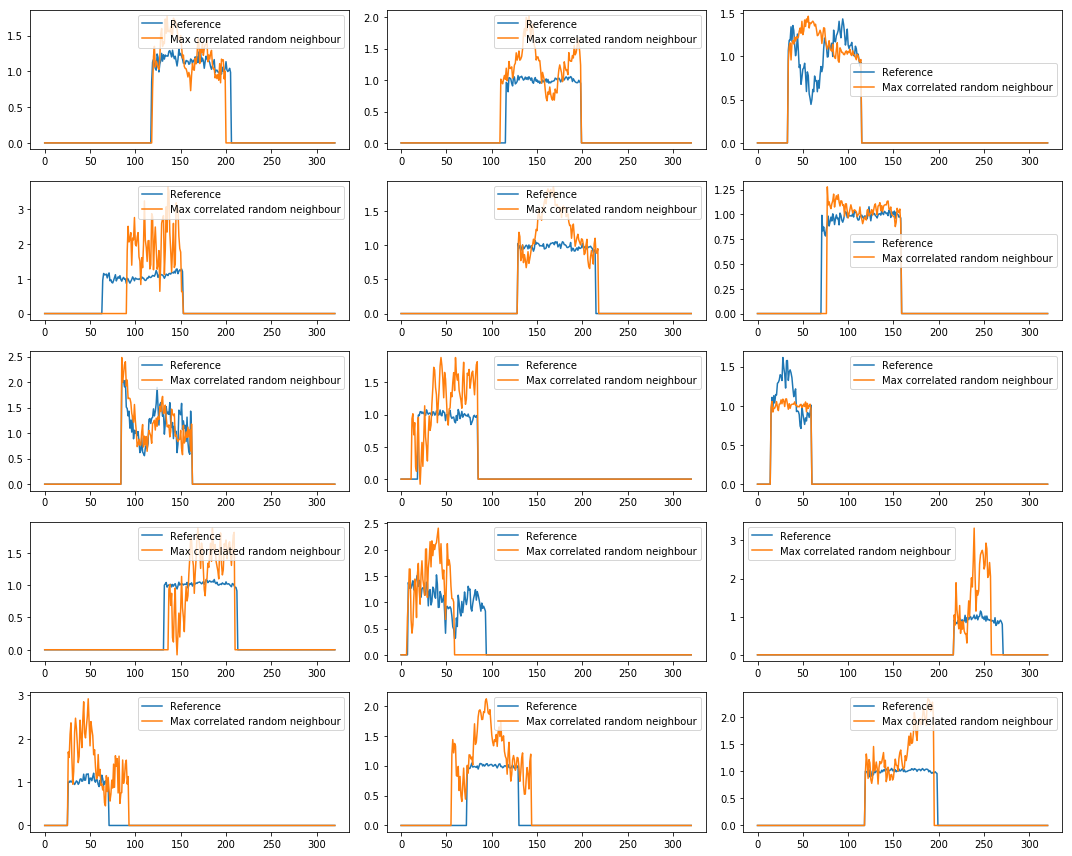

In [66]:
def cross_correlation(i, N_i, M, eps=0.5):
    """
    Args:
        i: Index of node i.
        N_i: Indicies for the neighbours of i.
        M: Graph signals.
        eps: Profile correlation treshold.
        
    Note: 
        * Using `full` mode potentially causing profiles to be truncated. 
          Since females are born at different times, some profiles may match
          others that originally started before the female was born. 
    """
    
    # NB: Need N_i to contain the actual neighbour indicies.
    N_i = check_iterable(N_i)
    
    tau_i_star, N_i_star, C_i_star = [], [], []
    for k, m_j in enumerate(M[N_i]):

        c = signal.correlate(m_j, M[i])
        c_max = max(c) / sum(c != 0)

        # Retain only the neighbours sufficiently correlated.
        if c_max >= eps:
                   
            tau_i_star.append(np.argmax(c) + 1 - len(m_j))
            
            N_i_star.append(N_i[k])
            C_i_star.append(c_max)

    return tau_i_star, N_i_star, C_i_star


def align(M_j, taus):
    
    M_j_aligned = []
    for m_j, tau in zip(M_j, taus):
        
        """
        T_j = np.argmax(m_j != 0)

        if tau > 0:
            k = T_j - tau
            
        elif tau < 0:
            k = abs(tau) + T_j
            
        else:
            k = T_j
        
        m_j_shifted = np.zeros_like(m_j)
        
        if k < 0:

            sliced_m_j = m_j[m_j > 0][abs(k):]   
            m_j_shifted[:len(sliced_m_j)] = sliced_m_j

        else:
            m_j_shifted[k:sum(m_j > 0) + k] = m_j[m_j > 0]
        """
        
        m_j_shifted = shift(m_j, -tau, cval=0)
        
        M_j_aligned.append(m_j_shifted)
        
    return np.array(M_j_aligned)


# Find optimal alignment of two random profiles.
np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=5, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demonstration).
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    tau_i_star, N_i_star, C_i_star = cross_correlation(i=i, N_i=N_i, M=M, eps=0.5)
    
    aligned_neighbours = align(M[N_i_star], tau_i_star)
    
    axis.plot(M[i], label="Reference")
    axis.plot(aligned_neighbours[np.argmax(C_i_star)], label="Max correlated random neighbour")
    axis.legend()
plt.tight_layout()

# Profile synthesis

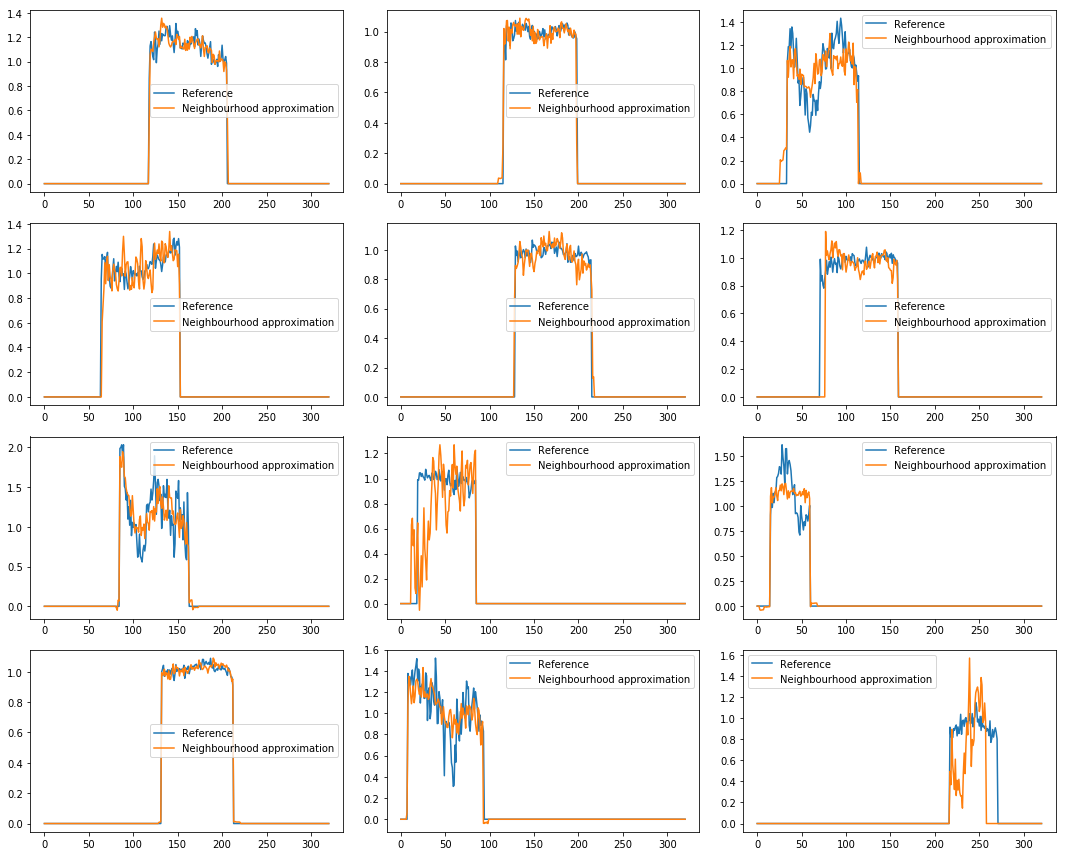

In [68]:
# TODO: Beta should be convex combination.
def synthesize(i, m_i, N_i, alpha=0):
        
    #model = Ridge(alpha=alpha, fit_intercept=False)
    #model.fit(np.transpose(N_i), m_i)
    
    #return np.transpose(N_i) @ model.coef_
    
    beta = np.linalg.inv(N_i @ N_i.T) @ N_i @ m_i
    
    return N_i.T @ beta


# Find use random profiles to approximate a reference profile.
np.random.seed(42)
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demonstration).
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    tau_i_star, N_i_star, C_i_star = cross_correlation(i=i, N_i=N_i, M=M, eps=0.5)
    
    aligned_neighbours = align(M[N_i_star], tau_i_star)
    
    axis.plot(M[i], label="Reference")
    axis.plot(synthesize(i, M[i], aligned_neighbours, alpha=0), label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

# Candidate adjacency

In [10]:
def candidate_adjacency(A, loss, n_active, n_candidates, rnd_state, update_j=False):
    """
    Args:
        A: Current adjacency matrix.
        n_active: Number of neighbourhoods to update.
        n_candidates: Number of neighbourhoods to compare in an update.
        update_j: Update neighbourhoods of both i and j.
    """
    
    active = rnd_state.choice(range(A.shape[0]), replace=False, 
                              size=min(A.shape[0], n_active), p=loss / sum(loss))
    A_new = A.copy()    

    for i in active:

        # Node is not connected.
        if sum(A[i]) < 1:
            A_new = random_update(A, A_new, i, rnd_state)
            
        else:
            A_new = cf_update(A, A_new, i, n_candidates, rnd_state)

    # Just in case.
    np.fill_diagonal(A_new, 0)

    # Sanity check.
    assert np.array_equal(A_new, A_new.T)
                
    return A_new


n = 8
A = intial_adjacency(n=n, p=0.5, seed=42)
rnd_state = np.random.RandomState(seed=42)
for i in range(3):
    
    A_new = candidate_adjacency(A, np.arange(n), 2, 4, rnd_state)
    
    assert not np.array_equal(A, A_new)
    A = A_new

# CF update

In [9]:
def cf_update(A, A_new, i, n_candidates, rnd_state):
    
    # Ensure i not in N_j.
    candidates = np.concatenate([np.arange(i), np.arange(i + 1, A.shape[0])])
    candidates = rnd_state.choice(candidates, replace=False, size=n_candidates)
    
    new_hood = None
    max_overlap = 0

    for j in candidates:

        overlap = neighbourhood_similarity(A[i], A[j])
        if overlap > max_overlap:

            new_hood = j
            max_overlap = overlap

    return update_neighbourhood(max_overlap, A_new, A, i, j, update_j=False)


A = intial_adjacency(n=5, p=0.1, seed=42)
A_new = intial_adjacency(n=5, p=0.5, seed=42)
rnd_state = np.random.RandomState(seed=42)
print(A_new)
print()
print(A)
print()
print(cf_update(A, A_new, 3, 4, rnd_state))

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0.]]

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 1. 0.]]


# Random update

In [8]:
def random_update(A, A_new, i, rnd_state):
    
    candidates = np.concatenate([np.arange(i), np.arange(i + 1, A.shape[0])])
    candidates = np.asarray([rnd_state.choice(candidates)])
        
    return update_neighbourhood(overlap=0, A_new=A_new, A=A, i=i, j=candidates, update_j=False)


A = intial_adjacency(n=5, p=0.1, seed=42)
A_new = intial_adjacency(n=5, p=0.5, seed=42)
rnd_state = np.random.RandomState(seed=42)
print(A_new)
print()
print(A)
print()
print(random_update(A, A_new, 1, rnd_state))

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0.]]

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]

[[0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0.]]


# Update neighbourhood

In [7]:
def update_neighbourhood(overlap, A_new, A, i, j, update_j=False):

    # Connect i and j.
    if overlap == 1:

        A_new[i, j] = 1
        A_new[j, i] = 1

    else:

        # Union of both neighbourhoods.
        N_new = np.squeeze(np.logical_or(A[i], A[j]))

        A_new[i, N_new] = 1
        A_new[N_new, i] = 1
        
        if update_j:
        
            A_new[j, N_new] = 1
            A_new[N_new, j] = 1

    return A_new
            
            
A = intial_adjacency(n=5, p=0.1, seed=42)
A_new = intial_adjacency(n=5, p=0.5, seed=42)
print(A_new)
print()
print(A)
print()
print(update_neighbourhood(0, A_new, A, 0, 2))
print()
print(update_neighbourhood(1, A_new, A, 0, 0))

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0.]]

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]

[[1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0.]]

[[1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0.]]


# Putting it together

In [21]:
def run_step(A, M, alpha=0, beta=0, eps=0):
    
    # Refined adjacency after checking correlations.
    A_refined = np.zeros_like(A)
    
    M_hat = np.zeros_like(M)
    for i, a in enumerate(A):
        
        # Node is not connected.
        if sum(a) < 1:
        
            M_hat[i] = np.zeros_like(M[i])
            continue
        
        tau_i_star, N_i_star, C_i_star = cross_correlation(i=i, N_i=np.squeeze(np.where(a)), M=M, eps=eps)
        
        # Avoid sum check as node can be connected to zero-index node.
        if np.size(N_i_star) == 0:
            
            M_hat[i] = np.zeros_like(M[i])
            continue
        
        A_refined[i, N_i_star] = 1
        A_refined[N_i_star, i] = 1
        
        M_hat[i] = synthesize(i, M[i], align(M[N_i_star], tau_i_star), alpha=alpha)
        
    # Just in case.
    np.fill_diagonal(A_refined, 0)

    # Sanity check.
    assert np.array_equal(A_refined, A_refined.T)
    
    return A_refined, energy(M, M_hat, A_refined, beta), M_hat

In [67]:
# NOTE: 
# * Code breaks with weighted adjacency.
# * Assume all nodes have at least one neighbour intially.
def main_procedure(A, M, num_epochs, n_active, n_candidates, 
                   eps=0.5, alpha=0, beta=0, seed=42, patience=10):
    """
    Args:
        patience: Maximum number of iterations without an update before exiting.
    """
    
    # Initial adjacency and energy.
    A, E, M_hat = run_step(A=A, M=M, alpha=alpha, beta=beta, eps=eps)
    
    # Temperature should be at the magnitude of energy levels.
    T = annealing_schedule(T0=E, x=np.arange(num_epochs))
    
    # Initialize loss.
    loss = np.linalg.norm(M - M_hat, axis=1) ** 2
    
    rnd_state = np.random.RandomState(seed=seed)
    
    for epoch, T_n in enumerate(T):
        
        A_new = candidate_adjacency(A, loss, n_active, n_candidates, update_j=False, rnd_state=rnd_state)
        
        A_new, E_new, M_hat_new = run_step(A_new, M=M, eps=eps, alpha=alpha, beta=beta)

        # Move on to next state.
        if p_accept(E, E_new, T_n) >= np.random.random():
                        
            A = A_new
            E = E_new
            M_hat = M_hat_new
            
            loss = np.linalg.norm(M - M_hat, axis=1) ** 2
        
        # TODO: Break if not updated in the last `patience` number of iterations.
        if epoch > patience:
            return A
    
    return A


n = 6
A_init = intial_adjacency(n=n, p=0.4, seed=42)
print(A_init)
print()

# Increase n_active to increase density in A. 
# Increase eps to decrease density in A. 
A_hat = main_procedure(A_init, M[:n], num_epochs=10, eps=0.55, n_active=2, n_candidates=4)
#np.save("A_hat.npy", A_hat)
print(A_hat)

np.array_equal(A_init, A_hat), np.sum(A_init), np.sum(A_hat)

[[0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]

[[0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


(False, 16.0, 10.0)

# Old gold

In [ ]:
def solve_M_hat(L, M, M_star, beta, gamma):
    """Solves \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M})."""
    
    return np.array(np.linalg.inv(np.eye(M.shape[0]) + gamma * L) @ (beta * M + M_star * (1 - beta)))


def objective(M, M_hat, M_star, L, beta):
    """Evaluate \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M})."""
    
    loss_M = beta * np.linalg.norm(M - M_hat) ** 2
    loss_local = (1 - beta) * np.linalg.norm(M_star - M_hat) ** 2
    loss_global = gamma * np.trace(M_hat.T @ L @ M_hat)
    
    return loss_M + loss_local + loss_global